<a href="https://colab.research.google.com/github/Noufal21/cat-vs-dog-classification-CNN-/blob/master/Cat_vs_Dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle --upgrade

In [ ]:
# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
api_token = {"username":"","key":""}
import json
import zipfile
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config path -p /content
!kaggle competitions download -c dogs-vs-cats
os.chdir('/content/')


In [8]:
import pandas as pd
import numpy as np

import os
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import  Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras import backend as K

from matplotlib import pyplot
from matplotlib import cm
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
from zipfile import ZipFile
with ZipFile('/content/test1.zip', 'r') as zipObj:
    print(zipObj)
    zipObj.extractall("data")

<zipfile.ZipFile filename='/content/test1.zip' mode='r'>


In [10]:
from zipfile import ZipFile
with ZipFile('/content/train.zip', 'r') as zipObj:
    print(zipObj)
    zipObj.extractall("data")

<zipfile.ZipFile filename='/content/train.zip' mode='r'>


In [100]:
filenames = os.listdir("/content/data/train")

cat = []

for file in filenames:
  classType = file.split('.')[0]
  if classType == "dog":
    cat.append(0)
  else:
    cat.append(1)


trainData = pd.DataFrame({"fileName" : filenames, 'categories' : cat})


In [101]:
trainData.head()

,fileName,categories
0,cat.820.jpg,1
1,cat.4321.jpg,1
2,dog.9365.jpg,0
3,dog.10464.jpg,0
4,cat.409.jpg,1


In [114]:
trainData["categories"] = trainData["categories"].replace({0: 'dog', 1: 'cat'}) 

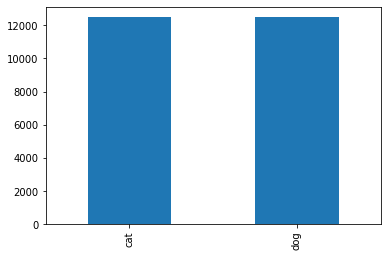

In [115]:
trainData["categories"].value_counts().plot(kind = "bar")

In [116]:
train_df, validate_df = train_test_split(trainData, test_size=0.20, random_state=20)

In [117]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/data/train/", 
    x_col='fileName',
    y_col='categories',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=32 
)

Found 20000 validated image filenames belonging to 2 classes.


In [118]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/data/train/", 
    x_col='fileName',
    y_col='categories',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=32
)

Found 5000 validated image filenames belonging to 2 classes.


In [124]:
def createModel( num_classes,input_shape):
  model = Sequential()
  model.add(Conv2D(32,kernel_size=(3,3),activation= "relu",input_shape = input_shape))
  model.add(MaxPool2D(pool_size=(2,2))) 
  model.add(Dropout(0.4))

  model.add(Conv2D(64,kernel_size=(3,3),activation= "relu"))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(128,kernel_size=(3,3),activation= "relu"))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Conv2D(256,kernel_size=(3,3),activation= "relu"))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(256,activation= 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.RMSprop(learning_rate= 0.001),metrics = ['accuracy'])

  return model
batch_size = 128
num_classes = 2
input_shape = (128,128,3)
model = createModel(num_classes,input_shape)

In [125]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_87 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_88 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 28, 28, 128)     

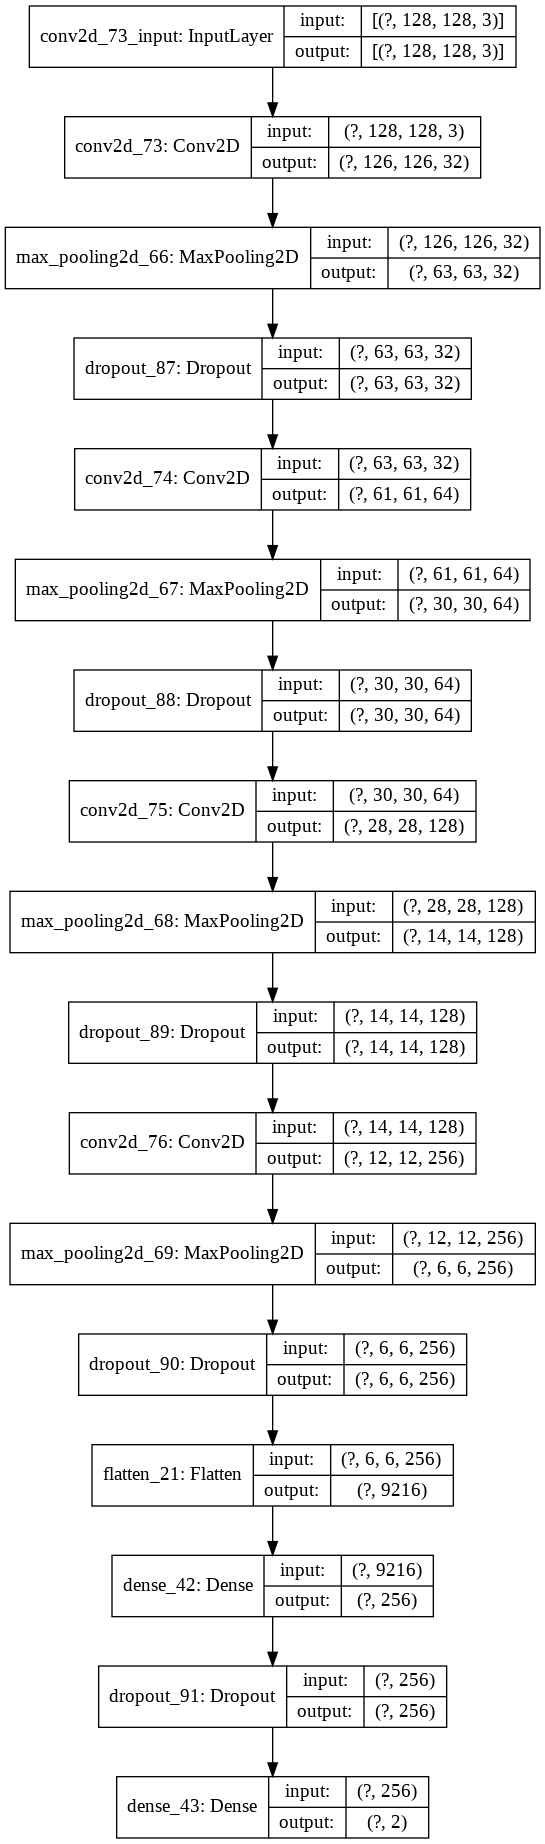

In [126]:
keras.utils.plot_model(model,show_shapes= True,show_layer_names=True)

In [127]:
earlyStop = EarlyStopping(patience = 10)

variable_gradient = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.00001)

In [128]:
epochs = 20
hist = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[earlyStop,variable_gradient]
)

Epoch 1/20
625/625 [==============================] - 134s 214ms/step - loss: 0.6851 - accuracy: 0.5773 - val_loss: 0.6117 - val_accuracy: 0.6622
Epoch 2/20
625/625 [==============================] - 134s 214ms/step - loss: 0.6302 - accuracy: 0.6510 - val_loss: 0.5678 - val_accuracy: 0.6990
Epoch 3/20
625/625 [==============================] - 134s 215ms/step - loss: 0.6020 - accuracy: 0.6817 - val_loss: 0.5249 - val_accuracy: 0.7428
Epoch 4/20
625/625 [==============================] - 134s 215ms/step - loss: 0.5777 - accuracy: 0.7078 - val_loss: 0.4826 - val_accuracy: 0.7600
Epoch 5/20
625/625 [==============================] - 132s 211ms/step - loss: 0.5556 - accuracy: 0.7247 - val_loss: 0.4841 - val_accuracy: 0.7650
Epoch 6/20
625/625 [==============================] - 130s 208ms/step - loss: 0.5437 - accuracy: 0.7352 - val_loss: 0.4794 - val_accuracy: 0.7788
Epoch 7/20
625/625 [==============================] - 130s 207ms/step - loss: 0.5391 - accuracy: 0.7421 - val_loss: 0.4219 -

In [129]:
model.save('dogvscat.h5')

In [130]:
test_filenames = os.listdir("/content/data/test1")
test_df = pd.DataFrame({
    'filenames': test_filenames
})


In [131]:
test_df.head()

,filenames
0,203.jpg
1,11276.jpg
2,1456.jpg
3,11368.jpg
4,12280.jpg


In [133]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    "/content/data/test1/", 
    x_col='filenames',
    y_col=None,
    target_size=(128,128),
    class_mode=None,
    batch_size=32
)

Found 12500 validated image filenames.


In [134]:
pred = model.predict(test_generator)

In [135]:
test_df["categories"] = np.argmax(pred, axis = -1)

In [136]:
test_df.head()

,filenames,categories
0,203.jpg,0
1,11276.jpg,1
2,1456.jpg,0
3,11368.jpg,1
4,12280.jpg,1


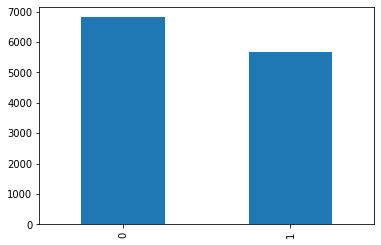

In [137]:
test_df["categories"].value_counts().plot(kind = "bar")

In [139]:
test_df["categories"] = test_df["categories"].replace({0: 'dog', 1: 'cat'}) 

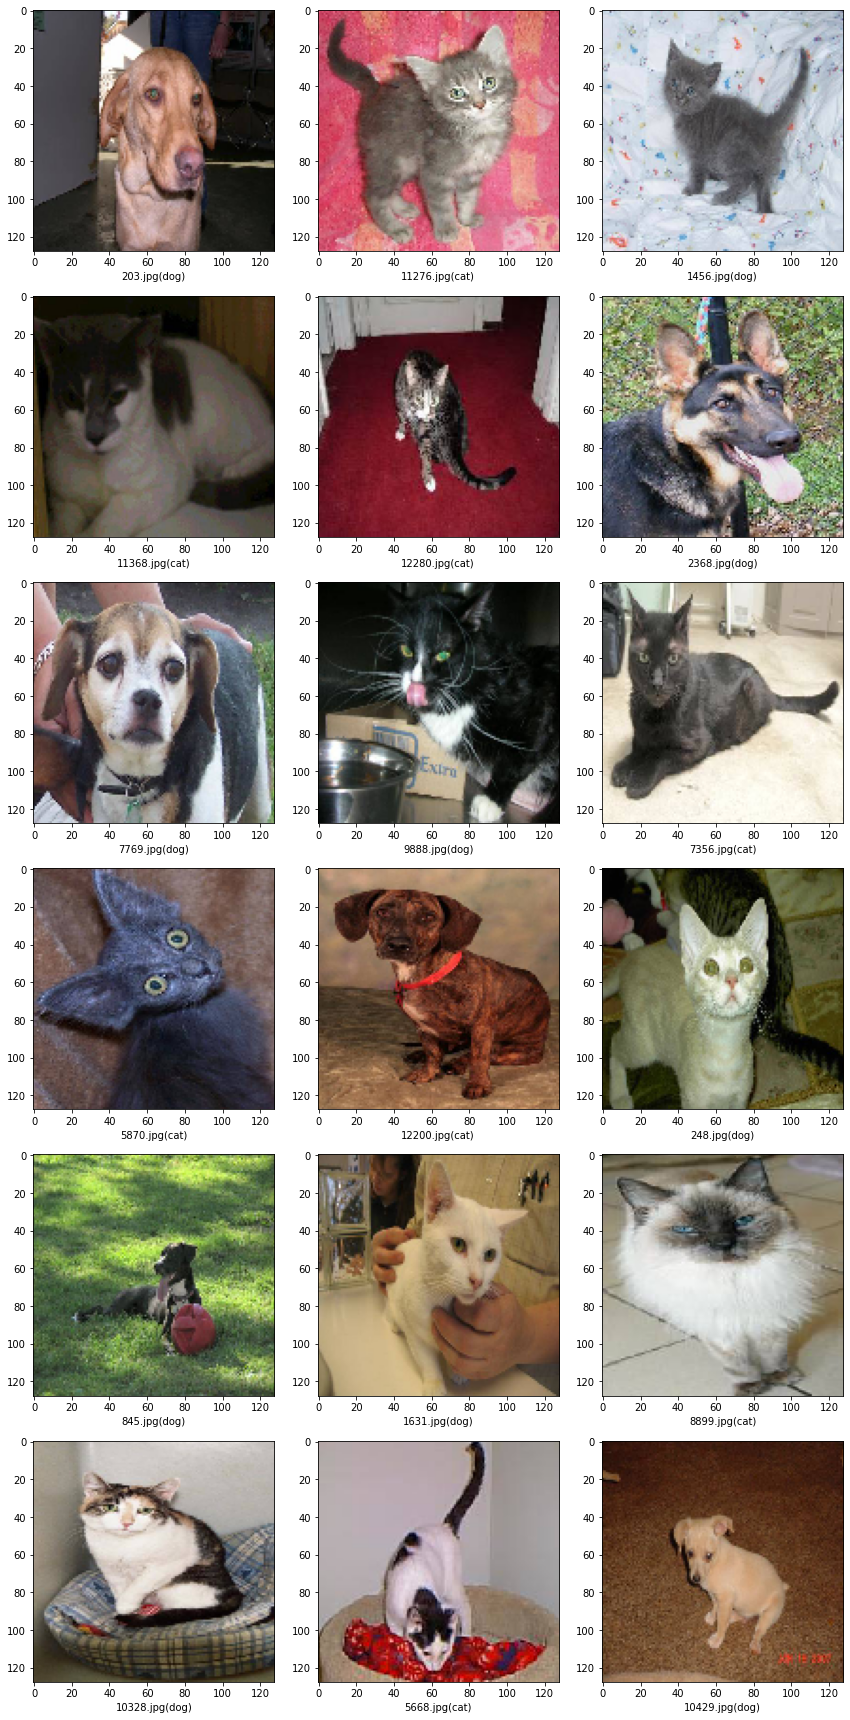

In [140]:
sample_test = test_df.head(18)
sample_test.head()
pyplot.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filenames']
    category = row['categories']
    img = load_img("/content/data/test1/"+filename, target_size=(128,128))
    pyplot.subplot(6, 3, index+1)
    pyplot.imshow(img)
    pyplot.xlabel(filename + '(' + "{}".format(category) + ')' )
pyplot.tight_layout()
pyplot.show()